# Learning and Decision Making

## Laboratory 5: Reinforcement learning

In the end of the lab, you should submit all code/answers written in the tasks marked as "Activity n. XXX", together with the corresponding outputs and any replies to specific questions posed to the e-mail <adi.tecnico@gmail.com>. Make sure that the subject is of the form [&lt;group n.&gt;] LAB &lt;lab n.&gt;.

### 1. The puddle world domain

Consider the puddleworld domain from the homework, depicted in the figure below.

<img src="puddleworld.png" width="400px">

In it, an all terrain vehicle must navigate a 20 &times; 20 gridworld. The three shaded cells in the upper right corner correspond to the goal state, while the L-shaped shaded cells in the middle of the grid correspond to a puddle in which the vehicle may get stuck and damaged. 

The vehicle has available the standard four actions, _up_, _down_, _left_ and _right_. Each action

* Succeeds and moves the vehicle to the adjacent cell in the corresponding direction with a probability of $0.92$; 
* Fails and moves the vehicle to any of the other 3 adjacent cells with a probability of $0.2$; 
* Fails and the vehicle remains in the same cell with a probability of $0.2$.

The vehicle incurs maximal cost ($1$) for standing in the darker part of the puddle; in the lighter part of the puddle, it incurs a cost of $0.5$. Each movement costs $0.05$ and the goal cells cost $0$.

The problem can be described as an MDP $(\mathcal{X},\mathcal{A},\mathbf{P},c,\gamma)$ as follows.

<IPython.core.display.Javascript object>


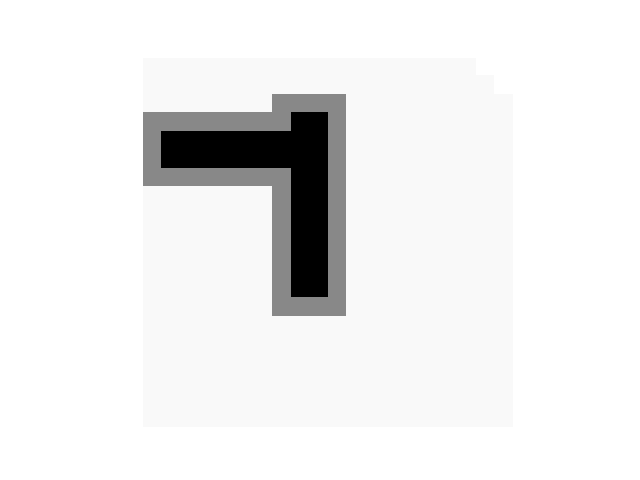

In [1]:
%matplotlib notebook
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

# Problem specific parameters
GRIDSIZE = 20

def puddlecost(x):
    ''' puddlecost : int -> int

        puddlecost(x) returns the cost for the puddle area corresponding to state x:
        * if x is in the dark puddle area, it returns 1;
        * if x is in the light puddle area, it returns 0.5;
        * otherwise, it returns 0.
        
    '''

    i = x // GRIDSIZE
    j = x % GRIDSIZE
    
    if (j in (4, 5) and i in range(1, 8)) or \
       (i in (8, 9) and j in range(3, 13)):
        return 1.0
    
    if (j in range(3, 7) and i in range(0, 9)) or \
       (i in range(7, 11) and j in range(2, 14)):
        return 0.5
    
    return 0

# -- End: puddlecost


np.set_printoptions(threshold=10)


# States
X = [(i, j) for i in range(GRIDSIZE) for j in range(GRIDSIZE)]
nX = len(X)

# Actions
A = ['U', 'D', 'L', 'R']
nA = len(A)

# Transition probabilities and cost
Pu = np.zeros((nX, nX))
Pd = np.zeros((nX, nX))
Pl = np.zeros((nX, nX))
Pr = np.zeros((nX, nX))

c = np.zeros((nX, nA))

for x in range(nX):
    (i, j) = X[x]
    
    xu = X.index((i, max(j - 1, 0)))
    xd = X.index((i, min(j + 1, GRIDSIZE - 1)))
    xl = X.index((max(i - 1, 0), j))
    xr = X.index((min(i + 1, GRIDSIZE - 1), j))
    
    # Successfull transition
    Pu[x, xu] += 0.92
    Pd[x, xd] += 0.92
    Pl[x, xl] += 0.92
    Pr[x, xr] += 0.92

    # Failed transition (stays in place)
    Pu[x, x] += 0.02
    Pd[x, x] += 0.02
    Pl[x, x] += 0.02
    Pr[x, x] += 0.02

    # Failed transition (oposite direction)
    Pu[x, xd] += 0.02
    Pd[x, xu] += 0.02
    Pl[x, xr] += 0.02
    Pr[x, xl] += 0.02

    # Failed transition (sideways)
    Pu[x, xl] += 0.02
    Pu[x, xr] += 0.02
    Pd[x, xl] += 0.02
    Pd[x, xr] += 0.02
    Pl[x, xu] += 0.02
    Pl[x, xd] += 0.02
    Pr[x, xu] += 0.02
    Pr[x, xd] += 0.02
    
    if x not in (GRIDSIZE * (GRIDSIZE - 2), GRIDSIZE * (GRIDSIZE - 1), GRIDSIZE * (GRIDSIZE - 1) + 1):
        c[x, :] = min(0.05 + puddlecost(x), 1)
    
P = [Pu, Pd, Pl, Pr]

# Discount
gamma = 0.95

# Observe cost function
plt.figure()
plt.imshow(c[:, 0].reshape(GRIDSIZE, GRIDSIZE).T, cmap='Greys', origin='upper')
plt.axis('off')
plt.show()

---

#### Activity 1.        

Compute the optimal $Q$-function for the MDP defined above using value iteration. As your stopping condition, use an error between iterations smaller than `1e-8`.

---

In [2]:
import time
# nX - number of states, nA - number of Actions
Q = np.zeros((nX,nA))
Q_new = [[],[],[],[]]
J = np.zeros((nX, 1))
err=1
i=0
t0 = time.time()
# Value iteration loop
while err > 1e-8:
    for j in range(4):
        Q_new[j] = c[:,j,None] + gamma * P[j].dot(J)
    J_new = np.min((Q_new[0],Q_new[1],Q_new[2],Q_new[3]), axis=0)
    Q_star = np.concatenate((Q_new[0],Q_new[1],Q_new[2],Q_new[3]),axis=1)
    err = np.linalg.norm(np.array(Q_star)-np.array(Q))
    i += 1
    J = J_new
    Q = Q_star
    
# Display time to compute (endtime-startime) and value iteration results
t1 = time.time()-t0
print("Time to compute Q*: %.6f seconds" % t1)
print("Number of iterations: %d" % i)
print("Q*:\n%s" % Q_star)

Time to compute Q*: 0.174720 seconds
Number of iterations: 252
Q*:
[[0.66620905 0.68217222 0.66620905 0.64867778]
 [0.66785408 0.70889182 0.68381725 0.66734816]
 [0.69667515 1.20781559 0.72174972 0.70663337]
 ...
 [0.60463209 0.64360831 0.63873085 0.62468735]
 [0.62676187 0.6632013  0.65874275 0.64568283]
 [0.64725131 0.66476979 0.67693514 0.66476979]]


---

#### Activity 2.        

Write down a Python function that, given a Q-function $Q$ and a state $x$, selects a random action using the $\epsilon$-greedy policy obtained from $Q$ for state $x$. Your function should receive an optional parameter, corresponding to $\epsilon$, with default value of 0.1. 

**Note:** In the case of two actions with the same value, your $\epsilon$-greedy policy should randomize between the two.

---

In [3]:
# Q-function Q, state x and eps
def chooseAction(Q, state, eps=0.1):
    Q_state = Q[X.index(state)]
    actions = [a for a in range(len(Q_state)) if Q_state[a] == min(Q_state)]
    return np.random.choice([np.random.choice(nA), np.random.choice(actions)], p=[eps, 1-eps])

### 2. Model-based learning

You will now run the model-based learning algorithm discussed in class, and evaluate its learning performance.

---

#### Activity 3.        

Run the model-based reinforcement learning algorithm discussed in class to compute $Q^*$ for $500,000$ iterations. Initialize each transition probability matrix as the identity and the cost function as all-zeros. Use an $\epsilon$-greedy policy with $\epsilon=0.1$ (use the function from Activity 2). Note that, at each step,

* You will need to select an action according to the $\epsilon$-greedy policy;
* The state and action, you will then compute the cost and generate the next state; 
* With this transition information (state, action, cost, next-state), you can now perform an update. 
* When updating the components $(x,a)$ of the model, use the step-size

$$\alpha_t=\frac{1}{N_t(x,a)+1},$$

where $N_t(x,a)$ is the number of visits to the pair $(x,a)$ up to time step $t$.

In order to ensure that your algorithm visits every state and action a sufficient number of times, after the boat reaches the goal cell, make one further step, the corresponding update, and then reset the position of the vehicle to a random state in the environment.

Plot the norm $\|Q^*-Q^{(k)}\|$ every 500 iterations of your method, where $Q^*$ is the optimal $Q$-function computed in Activity 1.

**Note:** The simulation may take a bit. Don't despair.

---

Time to compute Q_MB: 166.901904 seconds
||Q* - Qx|| -  [50.36989962 47.50700527 46.3535576  ...  3.74514658  3.74496504
  3.74484332]
Q_MB
[[0.66114852 0.67618979 0.66236714 0.6462774 ]
 [0.66510853 0.71062508 0.67894133 0.66822452]
 [0.7187523  1.17292782 0.7203334  0.70728526]
 ...
 [0.60291068 0.63995258 0.63470203 0.61925279]
 [0.6254575  0.65916945 0.65569172 0.64201412]
 [0.64670886 0.66212869 0.66608452 0.66295017]]


<IPython.core.display.Javascript object>


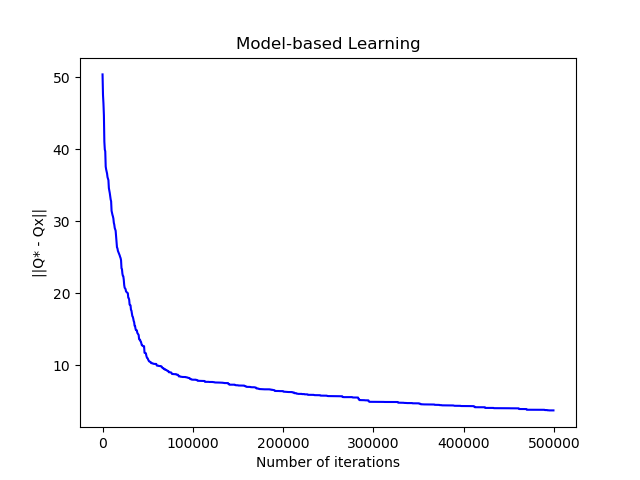

In [4]:
P_RL = [np.eye(nX, nX),np.eye(nX, nX),np.eye(nX, nX),np.eye(nX, nX)]
C_RL = np.zeros((nX, nA))
Q_MB = np.zeros((nX, nA))
N_MB = np.zeros((nX, nA))
goal_states = [(19,0),(18,0),(19,1)]
act3_errors = []
act3_iters = []

def drawPlot(values, norm, model, color):
    plt.figure()
    plt.title(model)
    plt.xlabel('Number of iterations')
    plt.ylabel('||Q* - Qx||')
    plt.plot(values, norm, color=color)
    plt.show()
    
def updateQ_MB(action, state):
    Q_MB[state][action] = C_RL[state][action] + gamma * np.dot(P_RL[action][state],np.min(Q_MB,axis=1))
    
def alpha(state, action):
    return 1/(N_MB[state][action] + 1)

def updateCost(action, state, cost):
    C_RL[state][action] = C_RL[state][action] + alpha(state,action)*(cost - C_RL[state][action])

def updateP(action, state, next_state):
    aux = np.zeros(nX)
    aux[next_state] = 1
    P_RL[action][state] = P_RL[action][state] + alpha(state,action)*(aux - P_RL[action][state])

t0 = time.time()
state = X[np.random.choice(range(len(X)))]
for i in range(500000):
    action = chooseAction(Q_MB, state)
    N_MB[X.index(state)][action] += 1
    cost = c[X.index(state)][action]
    next_state = X[np.random.choice(range(len(X)), p=P[action][X.index(state)])]
    
    # updates
    updateP(action, X.index(state), X.index(next_state))
    updateCost(action, X.index(state), cost)
    updateQ_MB(action, X.index(state))
    
    state = next_state if state not in goal_states else X[np.random.choice(range(len(X)))]
    if(not i%500):
        act3_errors.append(np.linalg.norm(Q_star - Q_MB))
        act3_iters.append(i)

t1 = time.time()-t0
print("Time to compute Q_MB: %.6f seconds" % t1)
print("||Q* - Qx|| - ", np.array(act3_errors))
print("Q_MB")
print(Q_MB)
drawPlot(act3_iters, act3_errors, "Model-based Learning", "blue")

### 3. Temporal-difference learning

You will now run both Q-learning and SARSA, and compare their learning performance with that of the model-based method just studied.

---

#### Activity 4.        

Repeat Activity 3 but using the $Q$-learning algorithm with a learning rate $\alpha=0.3$.

---

Time to compute Q_QL: 121.644043 seconds
||Q* - Qx|| -  [50.38308778 48.52551284 48.19222085 ...  5.3047479   5.30441037
  5.30229962]
Q_QL
[[0.66023349 0.67899813 0.66289199 0.64164611]
 [0.65876819 0.69148031 0.68021236 0.68025391]
 [0.82976608 1.13894657 0.82860965 0.71262319]
 ...
 [0.60284916 0.64391643 0.63940263 0.63203493]
 [0.62703415 0.65009264 0.6623067  0.64489119]
 [0.64757754 0.65637981 0.66768347 0.65355981]]


<IPython.core.display.Javascript object>


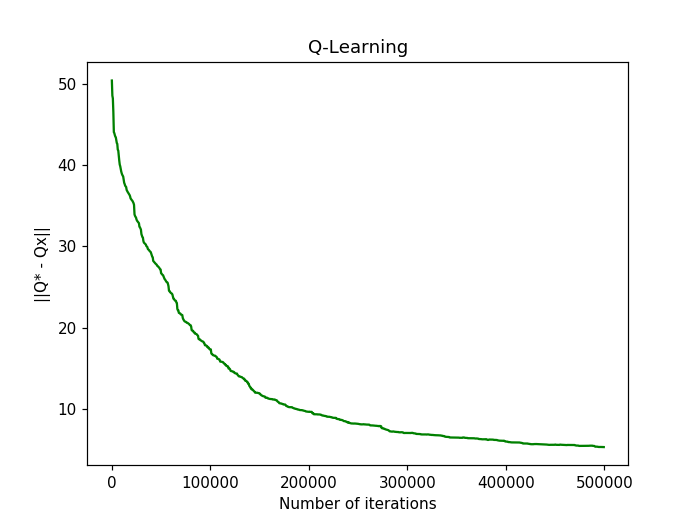

In [5]:
Q_QL = np.zeros((nX, nA))
alpha = 0.3
act4_errors = []
act4_iters = []

def updateQ_QL(action, state, next_state, cost): 
    Q_QL[state][action] = Q_QL[state][action] + alpha * (cost + gamma*np.min(Q_QL[next_state]) - Q_QL[state][action])

t0 = time.time()
state = X[np.random.choice(range(len(X)))]
for i in range(500000):
    action = chooseAction(Q_QL, state)
    cost = c[X.index(state)][action]
    next_state = X[np.random.choice(range(len(X)), p=P[action][X.index(state)])]
    
    # updates
    updateQ_QL(action, X.index(state), X.index(next_state), cost)
    
    state = next_state if state not in goal_states else X[np.random.choice(range(len(X)))]
    if(not i%500):
        act4_errors.append(np.linalg.norm(Q_star - Q_QL))
        act4_iters.append(i)

t1 = time.time()-t0
print("Time to compute Q_QL: %.6f seconds" % t1)
print("||Q* - Qx|| - ", np.array(act4_errors))
print("Q_QL")
print(Q_QL)
drawPlot(act4_iters, act4_errors, "Q-Learning", "green")

---

#### Activity 5.

Repeat Activity 4 but using the SARSA algorithm.

---

Time to compute Q_SARSA: 115.190961 seconds
||Q* - Qx|| -  [50.38328075 48.44944649 47.56024731 ...  5.66632995  5.65251796
  5.64999596]
Q_SARSA
[[0.75037291 0.74412146 0.73460046 0.7116623 ]
 [0.7119811  0.76186501 0.74011156 0.73138232]
 [0.73765159 1.24937588 0.80226995 0.83397419]
 ...
 [0.6504718  0.6835888  0.69330376 0.66589562]
 [0.68162709 0.70650929 0.70486863 0.70033054]
 [0.69798648 0.70700135 0.71313809 0.70820397]]


<IPython.core.display.Javascript object>


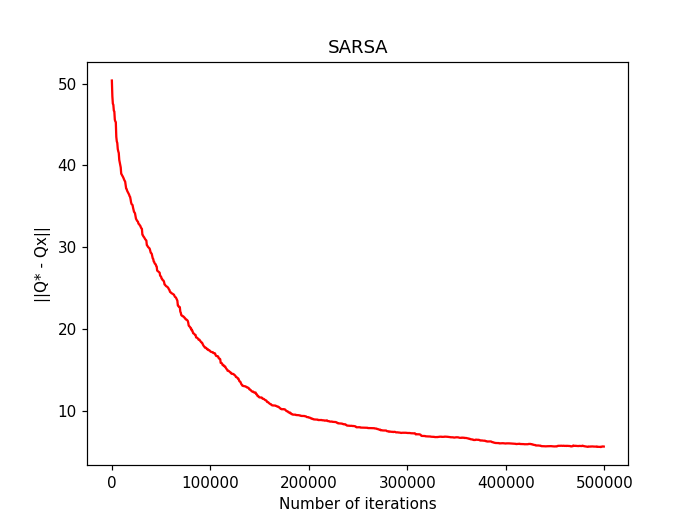

In [6]:
Q_SARSA = np.zeros((nX, nA))
alpha = 0.3
act5_errors = []
act5_iters = []

def updateQ_SARSA(action, next_action, state, next_state, cost): 
    Q_SARSA[state][action] = Q_SARSA[state][action] + alpha * (cost + gamma*Q_SARSA[next_state][next_action] - Q_SARSA[state][action])

t0 = time.time()
state = X[np.random.choice(range(len(X)))]
action = chooseAction(Q_SARSA, state)
for i in range(500000):
    cost = c[X.index(state)][action]
    next_state = X[np.random.choice(range(len(X)), p=P[action][X.index(state)])]
    next_action = chooseAction(Q_SARSA, next_state)
    # updates
    updateQ_SARSA(action, next_action, X.index(state), X.index(next_state), cost)
    
    state, random = (next_state, False) if state not in goal_states else (X[np.random.choice(range(len(X)))], True)
    action = next_action if not random else chooseAction(Q_SARSA, state)
    if(not i%500):
        act5_errors.append(np.linalg.norm(Q_star - Q_SARSA))
        act5_iters.append(i)

t1 = time.time()-t0
print("Time to compute Q_SARSA: %.6f seconds" % t1)
print("||Q* - Qx|| - ", np.array(act5_errors))
print("Q_SARSA")
print(Q_SARSA)
drawPlot(act5_iters, act5_errors, "SARSA", "red")

---

#### Activity 6.

Discuss the differences observed between the performance of the three methods.

---

<IPython.core.display.Javascript object>


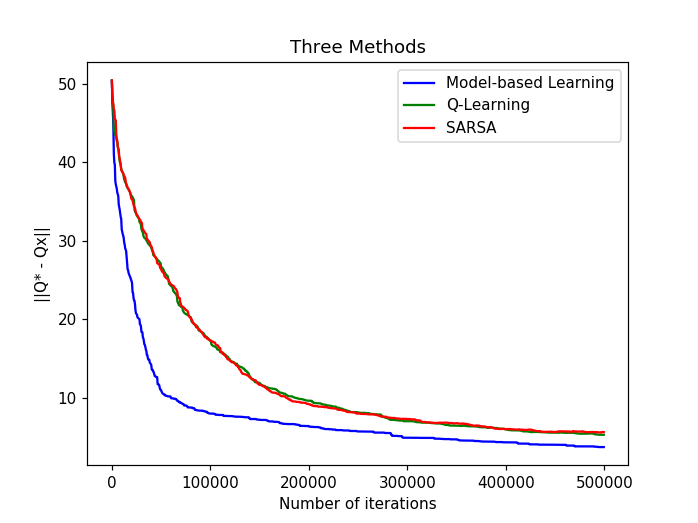

In [7]:
plt.figure()
plt.title("Three Methods")
plt.xlabel('Number of iterations')
plt.ylabel('||Q* - Qx||')
plt.plot(act3_iters, act3_errors, label="Model-based Learning", color="blue")
plt.plot(act4_iters, act4_errors, label="Q-Learning", color="green")
plt.plot(act5_iters, act5_errors, label="SARSA", color="red")
plt.legend()
plt.show()

__Comment__

- Model-based convergiu bastante mais rápido que os outros modelos, e convergiu mais. Problema demorou bastante mais tempo, pois requer bastante mais computação, visto que requer updates a tudo. Conseguir chegar a um erro de 3.74.

- Q-learning e o SARSA apesar de serem mais rápidos que o Model-based em termos de tempo, convergiram um pouco menos e demoraram mais iterações como se pode notar pelo gráfico em cima, isto devido a simplesmente fazerem updates à Q-function, assim com erros piores: Q-learning 5.30 e o SARSA com 5.64.

- O Q-learning é um algoritmo off-policy visto que aprende o valor de uma politica seguindo outra politica, enquanto o SARSA é um algoritmo on-policy visto que aprende o valor da politica que segue.

- Caso o eps seja 0 na função de eps_greedy, o algoritmo SARSA visto que é on-policy irá convergir mais do que está a convergir.

__(end of comment)__